# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [61]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        return  1 / (1 + np.exp(- X @ weights.T))
    
    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        X_ext = np.hstack([np.ones((x.shape[0], 1)), x])
        return np.mean(np.log(np.exp(- X_ext @ weights.T * y) + 1)) + np.square(weights).sum() / (2 * self.C)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        num_samples = X.shape[0]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        self.loss_history_ = np.array([])
        for i in range(self.max_iter):
            self.loss_history_ = np.append(self.loss_history_, self.get_loss(X, self.weights_, y))
            delta =  self.weights_ / self.C -\
            np.append(np.array([0]), sum((y[j] * X[j] * (1 - 1 / (1 + np.exp(- np.dot(X_ext[j],self.weights_) * y[j]))) for j in range(num_samples))) / num_samples) 
            self.weights_ -= self.eta * delta
            if (np.sqrt(np.sum(np.square(delta))) < self.tol):
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        y_pred_proba = self.predict_proba(X)
        def classify(x):
            if (x > 0.5):
                return 1
            else:
                return -1
        vfunc = np.vectorize(classify)
        y = vfunc(y_pred_proba)
        return y
        

In [52]:
z = np.array([])
for i in range(10):
    z = np.append(z, i)
z

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [5]:
from sklearn import datasets
from sklearn import metrics

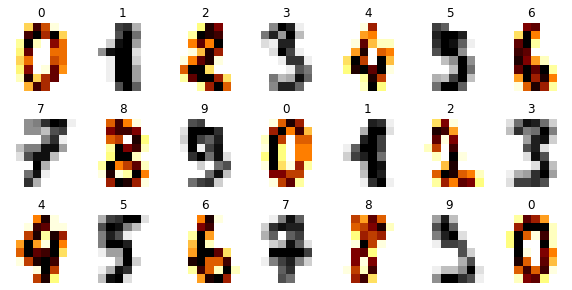

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [62]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [63]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [64]:
lr_clf.fit(X_train, y_train)

In [65]:
lr_clf.weights_

array([ 0.00000000e+00,  0.00000000e+00,  4.17536534e-05,  5.47668754e-04,
        2.21294363e-04,  4.87473904e-04,  1.35768963e-03,  5.97773138e-04,
        5.63674322e-05, -6.95894224e-07,  1.69102296e-04,  2.51913709e-04,
       -4.37021573e-04,  3.61864997e-04,  1.00487126e-03,  4.22755741e-04,
        2.57480863e-05,  3.47947112e-07, -1.14822547e-05, -7.24425887e-04,
       -2.62004175e-04,  8.75434934e-04,  4.15448852e-04, -8.42032011e-05,
       -5.21920668e-06,  0.00000000e+00, -2.21642310e-04, -5.71329158e-04,
        9.85734168e-04,  1.35073069e-03,  5.02087683e-04, -1.70494085e-04,
       -1.04384134e-06,  0.00000000e+00, -6.78148921e-04, -1.05149617e-03,
       -4.45372303e-05,  3.71607516e-04,  4.21016006e-04, -8.17675713e-05,
        0.00000000e+00, -5.21920668e-06, -5.34098817e-04, -2.03931802e-03,
       -8.43075852e-04,  1.04036186e-04, -1.23869172e-04, -1.78844816e-04,
       -1.32219903e-05, -4.52331246e-06, -9.42936674e-05, -1.11273486e-03,
       -5.09046625e-04, -

In [66]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [68]:
lr_clf.loss_history_

array([0.69314718])

In [69]:
model = CustomLogisticRegression()

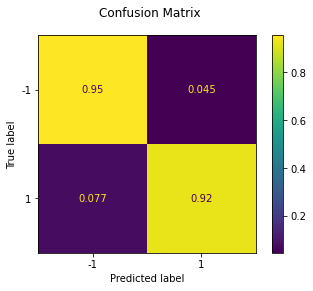

In [23]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [24]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [25]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

In [76]:
lr_clf = CustomLogisticRegression(max_iter=500, zero_init=True)
lr_clf.fit(X_train, y_train)

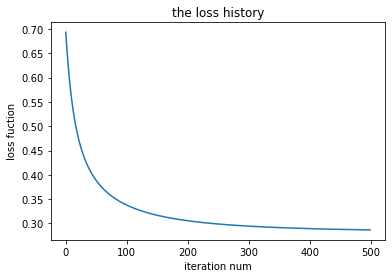

In [77]:
plt.plot(lr_clf.loss_history_)
plt.title('The loss history')
plt.ylabel('loss fuction')
plt.xlabel('iteration num')
plt.show()


**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

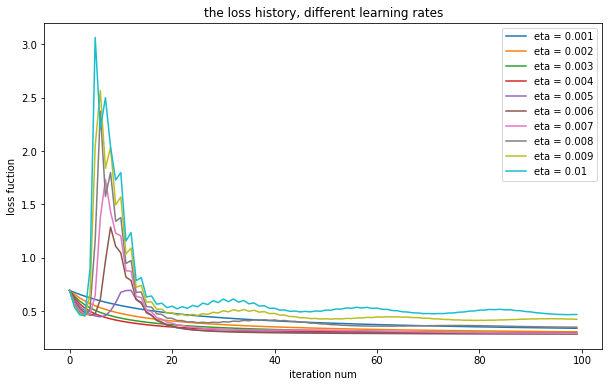

In [96]:
plt.figure(figsize=(10, 6))
ETAS = np.linspace(0.001, 0.01, 1 + 9)
for eta in ETAS:
    lr_clf = CustomLogisticRegression(eta=eta, max_iter=100, zero_init=True)
    lr_clf.fit(X_train, y_train)
    plt.plot(lr_clf.loss_history_, label= f'eta = {np.around(eta, decimals=3)}')
plt.title('the loss history, different learning rates')
plt.ylabel('loss fuction')
plt.xlabel('iteration num')
plt.legend()
plt.show()


< your thoughts >

По графику видно, что при eta <= 0.004 сходимость метода равномерная, при eta > 0.004 происходят скачки loss_function, причем при eta = 0.01, возможно, сходимости метода градиентного спуска не будет

**(0.5 points)** Try different regularization parameter values and compare the model quality.

In [93]:
reg_param = np.linspace(0.1, 1.6, 1 + 15)
reg_param

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6])

In [94]:
def fit_evaluate_custom(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)
print( 'C   |  (train_acc  ,  test_acc)')
for C in reg_param:
    model = CustomLogisticRegression(max_iter=100, C=C, zero_init=True)
    print(np.around(C, decimals=1), '  ', fit_evaluate_custom(model, X_train, y_train, X_test, y_test))


C   |  (train_acc  ,  test_acc)
0.1    (0.8761308281141267, 0.9)
0.2    (0.8789144050104384, 0.9055555555555556)
0.3    (0.8789144050104384, 0.9083333333333333)
0.4    (0.8803061934585943, 0.9111111111111111)
0.5    (0.8803061934585943, 0.9111111111111111)
0.6    (0.8810020876826722, 0.9111111111111111)
0.7    (0.8810020876826722, 0.9111111111111111)
0.8    (0.8810020876826722, 0.9111111111111111)
0.9    (0.8810020876826722, 0.9111111111111111)
1.0    (0.8810020876826722, 0.9111111111111111)
1.1    (0.8810020876826722, 0.9111111111111111)
1.2    (0.8810020876826722, 0.9111111111111111)
1.3    (0.8810020876826722, 0.9111111111111111)
1.4    (0.8816979819067502, 0.9111111111111111)
1.5    (0.8816979819067502, 0.9111111111111111)
1.6    (0.8816979819067502, 0.9111111111111111)


< your thoughts >

С ростом параметра C модель улучшается

**(0.5 points)** Compare zero initialization and random initialization. 

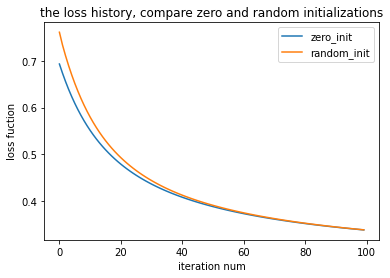

In [81]:
lr_clf = CustomLogisticRegression(max_iter=100, zero_init=True)
lr_clf.fit(X_train, y_train)
lr_clf1 = CustomLogisticRegression(max_iter=100, zero_init=False)
lr_clf1.fit(X_train, y_train)
plt.plot(lr_clf.loss_history_, label= 'zero_init')
plt.plot(lr_clf1.loss_history_, label= 'random_init')
plt.title('the loss history, compare zero and random initializations')
plt.ylabel('loss fuction')
plt.xlabel('iteration num')
plt.legend()
plt.show()

< your thoughts >

При увеличении числа итераций начальные условия для коэффициентов не играют большой роли. 

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [252]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        return np.array([[np.sqrt(np.sum(np.square(X[i] - Y[j]))) for j in range(Y.shape[0])] for i in range(X.shape[0])])
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        #classes = np.unique(y)
        a = pd.DataFrame(zip(y, weights), columns=['class', 'weights'])
        p = np.array([])
        for i in self.classes_:
            p = np.append(p, a[a['class'] == i]['weights'].sum())
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = 1 / (P + self.eps)
            y = np.array([[]])
            for i in range(X.shape[0]):
                a = pd.DataFrame(zip(self.y, weights_of_points[i]), columns=['class', 'weights'])
                a = a.sort_values(by='weights',ascending=False).head(self.n_neighbors)
                b = self.get_class_weights(a['class'].values, a['weights'].values)
                y = np.append(y, b / b.sum())
            return y.reshape(X.shape[0], len(self.classes_))
        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        prob_classes = self.predict_proba(X)
        y = np.array([])
        for i in range(X.shape[0]):
            a = pd.DataFrame(zip(self.classes_, prob_classes[i]), columns=['class', 'probab'])
            y = np.append(y, a.sort_values(by='probab',ascending=False).head(1)['class'].iloc[0])
        return y

In [253]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [238]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [239]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

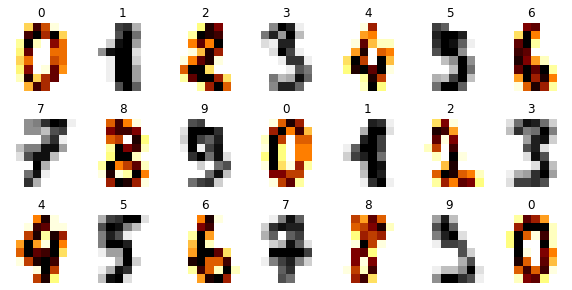

In [240]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [254]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [242]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

In [255]:
model.predict(X_test)

array([6., 9., 3., 7., 2., 1., 5., 2., 5., 2., 1., 9., 4., 0., 4., 2., 3.,
       7., 8., 8., 4., 3., 9., 7., 5., 6., 3., 5., 6., 3., 4., 9., 1., 4.,
       4., 6., 9., 4., 7., 6., 6., 9., 1., 3., 6., 1., 3., 0., 6., 5., 5.,
       1., 9., 5., 6., 0., 9., 0., 0., 1., 0., 4., 5., 2., 4., 5., 7., 0.,
       7., 5., 9., 9., 5., 4., 7., 0., 4., 5., 5., 9., 9., 0., 2., 3., 8.,
       0., 6., 4., 4., 9., 1., 2., 8., 3., 5., 2., 9., 0., 4., 4., 4., 3.,
       5., 3., 1., 3., 5., 9., 4., 2., 7., 7., 4., 4., 1., 9., 2., 7., 8.,
       7., 2., 6., 9., 4., 0., 7., 2., 7., 5., 8., 7., 5., 7., 9., 0., 6.,
       6., 4., 2., 8., 0., 9., 4., 6., 9., 9., 6., 9., 0., 3., 5., 6., 6.,
       0., 6., 4., 3., 9., 3., 4., 7., 2., 9., 0., 4., 5., 3., 6., 5., 9.,
       9., 8., 4., 2., 1., 3., 7., 7., 2., 2., 3., 9., 8., 0., 3., 2., 2.,
       5., 6., 9., 9., 4., 1., 5., 4., 2., 3., 6., 4., 8., 5., 9., 5., 7.,
       8., 9., 4., 8., 1., 5., 4., 4., 9., 6., 1., 8., 6., 0., 4., 5., 2.,
       7., 4., 6., 4., 5.

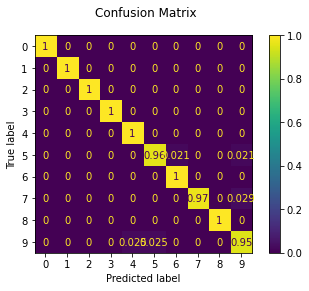

In [256]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [257]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

Процент неточностей 12.2
В случае, если вероятности классов одинаковые, то вопрос, какой из классов нужно выбрать. В моей реализации я брала первый.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

In [258]:
neighbors_num = np.linspace(2, 10, 1 + 8, dtype=int)
neighbors_num

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

In [260]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
neighbors_num = np.linspace(2, 10, 1 + 8, dtype=int)
print('neighbors     |  (train_acc  ,  test_acc)')
for n in neighbors_num:
    model = CustomKNeighborsClassifier(n_neighbors=n, weights='distance')
    print(n, '  ', fit_evaluate_custom(model, X_train, y_train, X_test, y_test))

neighbors     |  (train_acc  ,  test_acc)
2    (1.0, 0.9777777777777777)
3    (1.0, 0.9833333333333333)
4    (1.0, 0.9833333333333333)
5    (1.0, 0.9861111111111112)
6    (1.0, 0.9888888888888889)
7    (1.0, 0.9888888888888889)
8    (1.0, 0.9861111111111112)
9    (1.0, 0.9805555555555555)
10    (1.0, 0.9805555555555555)


< your thoughts >

При увеличении числа ближайших соседей точность не улучшается вообще говоря. По полученным результатам оптимальным является 6 или 7 соседей. И действительно, при увеличении числа соседей "границы" классов должны "сглаживаться"

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

In [261]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
print('distance: (train_acc  ,  test_acc)')
print(fit_evaluate_custom(model, X_train, y_train, X_test, y_test))

model1 = CustomKNeighborsClassifier(n_neighbors=5)
print('uniform: (train_acc  ,  test_acc)')
print(fit_evaluate_custom(model1, X_train, y_train, X_test, y_test))


distance: (train_acc  ,  test_acc)
(1.0, 0.9861111111111112)
uniform: (train_acc  ,  test_acc)
(0.10090466249130133, 0.09166666666666666)


< your thoughts >

В нашем случае лучше использовать 'distance' веса, т.к. равномерное расрелеление весов приведет к тому, 
что каждый образец будет помечен как 1 класс


**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

In [ ]:
Можно попробовать L1 метрику для данной задачи

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [263]:
PATH = "./data/"

In [277]:
#data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv'))

In [278]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [279]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 9.2+ MB


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [280]:
data.groupby(by='Sex')['PassengerId'].count()

Sex
female    43886
male      56114
Name: PassengerId, dtype: int64

In [281]:
data.groupby(by=['Sex','Survived'])['PassengerId'].count()

Sex     Survived
female  0           12660
        1           31226
male    0           44566
        1           11548
Name: PassengerId, dtype: int64

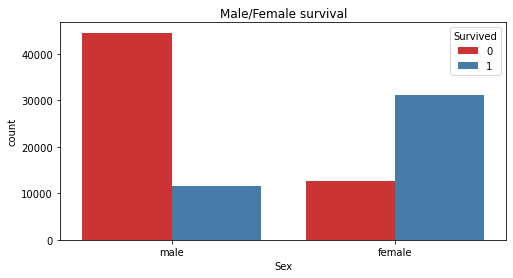

In [294]:
plt.figure(figsize=(8,4))
sns.countplot(x="Sex", hue="Survived", data=data, palette="Set1").set(title="Male/Female survival");

< your thoughts >

На корабле 43886 женщин и 56114 мужчин, процент выживания у женщин выше. Принцип "женщины и дети первыми" работал

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [300]:
def age_class(x):
    if (x <= 10):
        return '0-10'
    elif (x > 10) & (x <=20):
        return '10-20'
    elif (x> 20) & (x<=30):
        return '20-30'
    elif (x> 30) & (x<=40):
        return '30-40'
    elif (x> 40) & (x<=50):
        return '40-50'
    elif (x> 50) & (x<=60):
        return '50-60'
    elif (x> 60) & (x<=70):
        return '60-70'
    elif (x> 70) & (x<=80):
        return '70-80'
    elif (x> 80) & (x<=100):
        return '80-100'

vfunc = np.vectorize(age_class)
data['age_class'] = vfunc(data['Age'])

D:\anacondas3\lib\site-packages\numpy\lib\function_base.py:2197: RuntimeWarning: invalid value encountered in age_class (vectorized)
  outputs = ufunc(*inputs)


In [303]:
data['Age'].describe()

count    96708.000000
mean        38.355472
std         18.313556
min          0.080000
25%         25.000000
50%         39.000000
75%         53.000000
max         87.000000
Name: Age, dtype: float64

In [304]:
data.groupby(by='Survived')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Survived,,,,,,,,
0,55290.0,36.708695,17.809058,0.08,24.0,36.0,52.0,83.0
1,41418.0,40.553799,18.742172,0.08,27.0,43.0,55.0,87.0


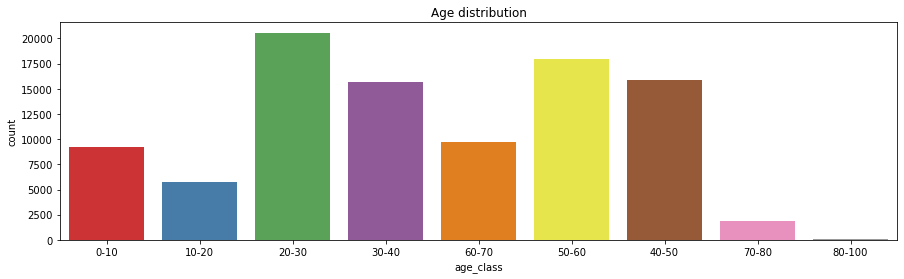

In [302]:
plt.figure(figsize=(15,4))
sns.countplot(x="age_class", data=data, palette="Set1").set(title="Age distribution");

< your thoughts >

Средний возраст пассажиров 38 лет. Средний возраст среди выживших 40, среди умерший -- ~37

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

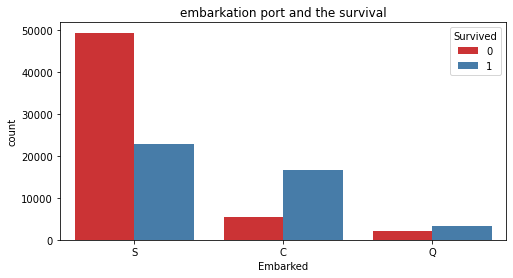

In [307]:
plt.figure(figsize=(8,4))
sns.countplot(x="Embarked", hue="Survived", data=data, palette="Set1").set(title="embarkation port and the survival");

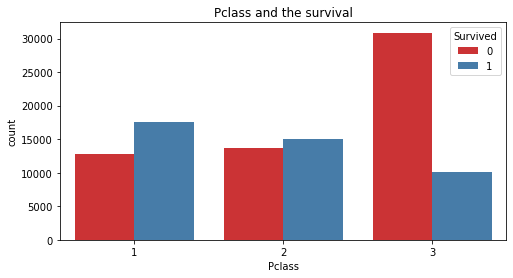

In [311]:
plt.figure(figsize=(8,4))
sns.countplot(x="Pclass", hue="Survived", data=data, palette="Set1").set(title="Pclass and the survival");

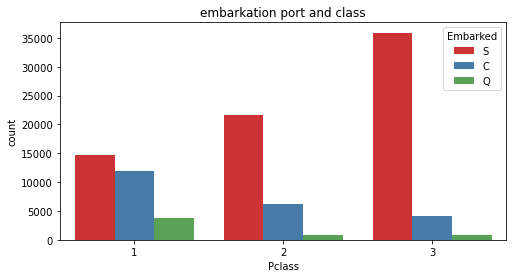

In [310]:
plt.figure(figsize=(8,4))
sns.countplot(x="Pclass", hue="Embarked", data=data, palette="Set1").set(title="embarkation port and class");

< your thoughts >

In [ ]:
Наибольшее число пассажиров село на корабль в Southampton, поэтому среди выживших больше тех, 
кто садился на корабль в Southampton.Наибольший процент выживаемости у пассажиров первого класса.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [321]:
missing_data = pd.DataFrame()
missing_data["missing"] = data.isnull().sum()[data.isnull().sum() > 0].sort_values(ascending=False)
missing_data["missing_percent"] = missing_data["missing"]/data.shape[0]*100
missing_data

,missing,missing_percent
Cabin,67866,67.866
Ticket,4623,4.623
Age,3292,3.292
Embarked,250,0.250
Fare,134,0.134


Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

In [ ]:
Можно исключить из рассмотрения кабину, так как там наибольший процент отсутствующих данных (хотя можно исследовать зависимость
кабины и выживаемости). Так как процент утерянных данных в остальных столбцах незначительный, то можно заполнить их средним
значением для признаков "Age", "Fare". Для "Embarked" недостающие можно заполнить наиболее часто встречающимся, т.е. "S". 
Также можно ислючить из рассмотрения признак "Ticket".

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.